In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import keras 
from keras.models import Sequential
from keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import MaxPooling2D, Flatten, Dense,BatchNormalization,GlobalAveragePooling2D,Conv2D,Dropout,Flatten,Rescaling,Input
from keras import regularizers
from keras.callbacks import EarlyStopping,ModelCheckpoint

import os
import random
import cv2

2025-06-12 10:56:25.703710: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-12 10:56:25.711640: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-12 10:56:25.771063: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-12 10:56:25.827703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749736585.881191   49931 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749736585.89

In [2]:
# data_path = r"C:\pastaImagensMangas"
data_path = "../../MangoLeaf"
img_size = (224,224)
batch_size = 32
mode = "rgb"
epochs = 50

In [3]:
def df_maker(path):
    file_paths = []
    labels = []

    folds = os.listdir(path)
    for fold in folds:
        fold_path = os.path.join(path,fold)
        file_list = os.listdir(fold_path)
        for file in file_list:
            file_path = os.path.join(fold_path,file)
            file_paths.append(file_path)
            labels.append(fold)


    file_series = pd.Series(file_paths,name="file_paths")
    label_series = pd.Series(labels,name="labels")

    df = pd.concat([file_series,label_series],axis=1)
    return df

In [4]:
df = df_maker(data_path)
df

,file_paths,labels
0,../../MangoLeaf/Powdery Mildew/20211109_121910...,Powdery Mildew
1,../../MangoLeaf/Powdery Mildew/20211109_122021...,Powdery Mildew
2,../../MangoLeaf/Powdery Mildew/IMG_20211107_11...,Powdery Mildew
3,../../MangoLeaf/Powdery Mildew/20211109_121919...,Powdery Mildew
4,../../MangoLeaf/Powdery Mildew/20211109_121938...,Powdery Mildew
...,...,...
3995,../../MangoLeaf/Sooty Mould/IMG_20211108_12092...,Sooty Mould
3996,../../MangoLeaf/Sooty Mould/IMG_20211108_12101...,Sooty Mould
3997,../../MangoLeaf/Sooty Mould/IMG_20211108_12082...,Sooty Mould
3998,../../MangoLeaf/Sooty Mould/IMG_20211212_14540...,Sooty Mould


In [5]:
train_df,test_val_df= train_test_split(df ,train_size= 0.8, shuffle= True, random_state= 7, stratify=df["labels"])
test_df,val_df= train_test_split(test_val_df ,train_size= 0.5, shuffle= True, random_state= 7, stratify=test_val_df["labels"])

In [6]:
df.labels.value_counts()

labels
Powdery Mildew      500
Cutting Weevil      500
Bacterial Canker    500
Healthy             500
Gall Midge          500
Anthracnose         500
Die Back            500
Sooty Mould         500
Name: count, dtype: int64

In [7]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_data = train_datagen.flow_from_dataframe(
    train_df,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    color_mode= mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
)
test_data = test_datagen.flow_from_dataframe(
    test_df,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    color_mode= mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
)
val_data = val_datagen.flow_from_dataframe(
    val_df,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    color_mode= mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
)

Found 3200 validated image filenames belonging to 8 classes.
Found 400 validated image filenames belonging to 8 classes.
Found 400 validated image filenames belonging to 8 classes.


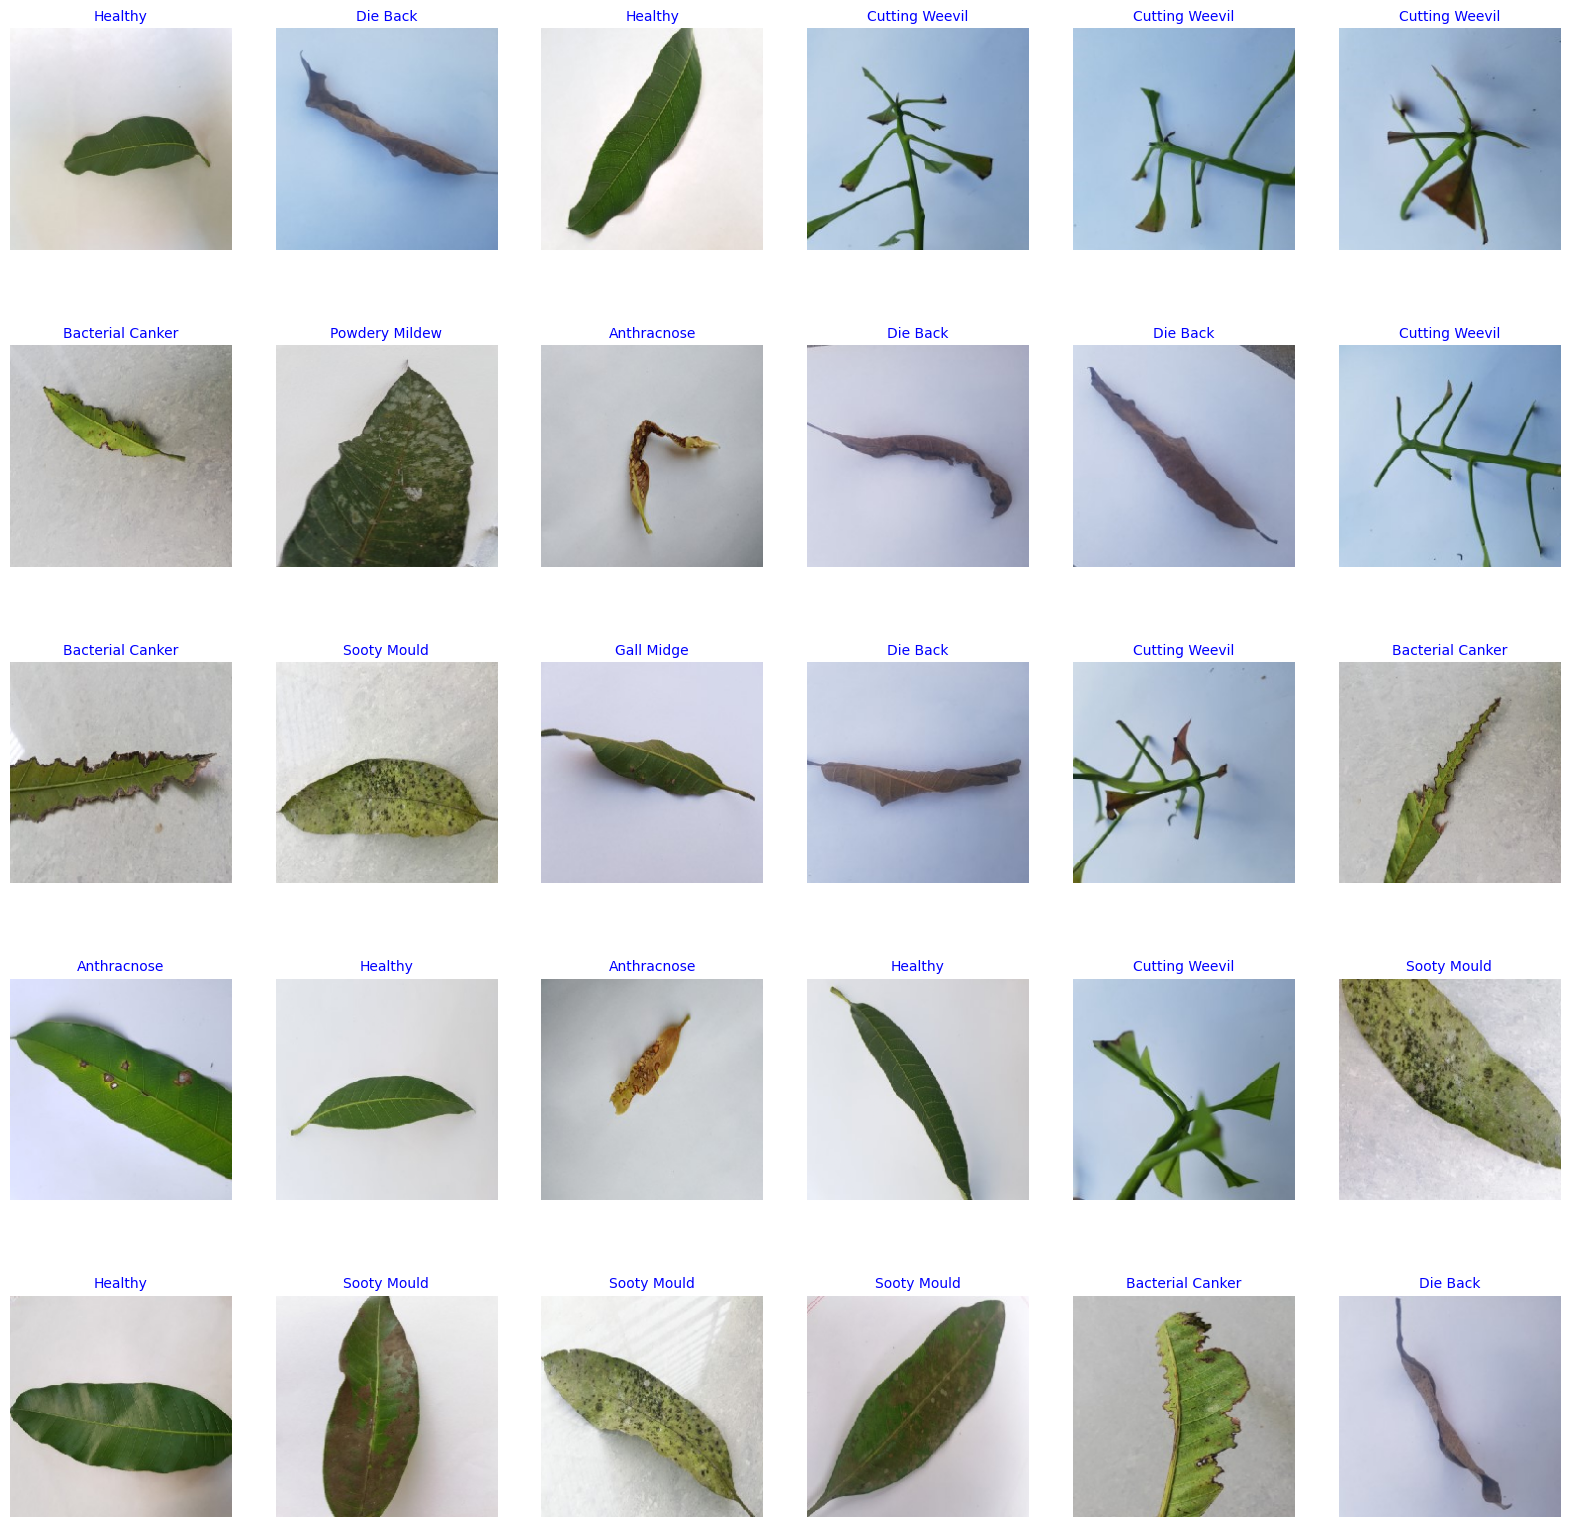

In [8]:
g_dict = train_data.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_data)      # get a batch size samples from the generator
# # difference between next iterator and for iterator


plt.figure(figsize= (20, 24))

for i in range(30):
    plt.subplot(6, 6, i + 1)
    image = images[i]/255
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 10)
    plt.axis('off')

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
import tensorflow as tf

def create_lightweight_model(input_shape, num_classes):
    model = Sequential()

    # Definir explicitamente a camada de entrada
    model.add(Input(shape=input_shape))
    
    # Primeira camada convolucional
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Segunda camada convolucional
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Terceira camada convolucional
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Quarta camada convolucional
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Quinta camada convolucional
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Sexta camada convolucional
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Achatar as saídas das camadas convolucionais
    model.add(Flatten())
    
    # Camada densa com 64 neurônios e ativação ReLU
    model.add(Dense(64, activation='relu'))
    
    # Camada de saída com softmax para classificação
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Parâmetros de entrada e saída
input_shape = (224, 224, 3)
num_classes = len(classes)

# Criar e compilar o modelo
model = create_lightweight_model(input_shape, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

E0000 00:00:1749736627.421111   49931 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1749736627.421550   49931 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
# Resumo do modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,784 (671.03 KB)

 Trainable params: 171,784 (671.03 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Treinamento do modelo
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    steps_per_epoch=len(train_data),
    validation_steps=len(val_data)
)

print("ok")

Epoch 1/50


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 443ms/step - accuracy: 0.2162 - loss: 3.6119 - val_accuracy: 0.4900 - val_loss: 1.2540
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 444ms/step - accuracy: 0.5289 - loss: 1.2259 - val_accuracy: 0.6075 - val_loss: 1.0555
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 410ms/step - accuracy: 0.7176 - loss: 0.7341 - val_accuracy: 0.7125 - val_loss: 0.8182
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 430ms/step - accuracy: 0.7768 - loss: 0.5887 - val_accuracy: 0.8500 - val_loss: 0.3606
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 422ms/step - accuracy: 0.8441 - loss: 0.4263 - val_accuracy: 0.8575 - val_loss: 0.3507
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 404ms/step - accuracy: 0.8592 - loss: 0.4084 - val_accuracy: 0.8450 - val_loss: 0.4817
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 380ms/step - accuracy: 0.8777 - loss: 0.3341 - val_accuracy: 0.9000 - val_loss: 0.2767
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 371ms/step - accuracy: 0.9178 - loss: 0.2290 - val

In [12]:
_history_dict = history.history
if not _history_dict:
    vals = pd.DataFrame()  # Create an empty DataFrame if history is empty
else:
    # Find the minimum length of all metric lists.
    # This handles cases where some lists might be empty (len=0), making min_length=0.
    # It assumes all values in _history_dict are iterables for which len() is defined (e.g., lists),
    # which is standard for Keras history.history.
    min_length = min(len(v) for v in _history_dict.values())
    
    # Truncate all lists in the history dictionary to this minimum length.
    # If min_length is 0, all lists in processed_history will become empty.
    processed_history = {key: value[:min_length] for key, value in _history_dict.items()}
    
    # Create the DataFrame from the processed history.
    # If processed_history contains empty lists, an empty DataFrame (with columns but no rows) will be created.
    vals = pd.DataFrame(processed_history)
vals = vals.rename(columns={"loss":"Train Loss","val_loss":"Validation Loss","accuracy":"Train Accuracy","val_accuracy":"Validation Accuracy"})

In [13]:
iplot(px.line(data_frame=vals,
              y = ["Train Accuracy","Validation Accuracy"],
              labels={"index":"epochs","value":"accuracy"},
              title = "Accuracy",
              template="plotly_dark"))

In [14]:
# Salvar o modelo
model.save('models/lcnn_v2.keras')

from tensorflow import keras
# model = keras.models.load_model('modelo_lcnn_versao4.keras')
model = keras.models.load_model('models/lcnn_v2.keras')

In [15]:
predictions = model.predict(test_data)
y_pred = np.argmax(predictions, axis = 1)
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step


                  precision    recall  f1-score   support

     Anthracnose       1.00      1.00      1.00        50
Bacterial Canker       0.96      1.00      0.98        50
  Cutting Weevil       0.98      1.00      0.99        50
        Die Back       1.00      1.00      1.00        50
      Gall Midge       0.98      0.90      0.94        50
         Healthy       0.98      1.00      0.99        50
  Powdery Mildew       1.00      0.94      0.97        50
     Sooty Mould       0.92      0.98      0.95        50

        accuracy                           0.98       400
       macro avg       0.98      0.98      0.98       400
    weighted avg       0.98      0.98      0.98       400



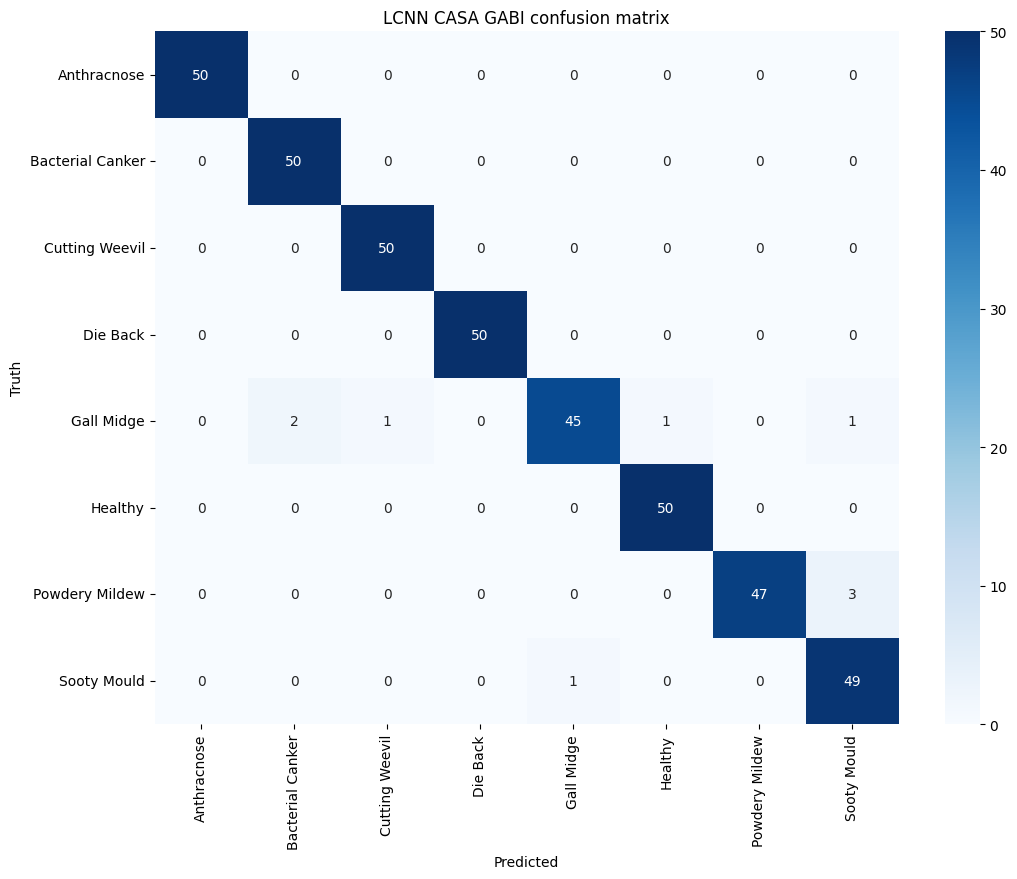

In [16]:
print(classification_report(y_true,y_pred, target_names=class_labels))

plt.figure(figsize = (12,9))
cm = confusion_matrix(y_true, y_pred)
# sns.heatmap(cm, annot=True,fmt='d',cmap= plt.cm.Blues)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("LCNN CASA GABI confusion matrix")
plt.show()